<a href="https://colab.research.google.com/github/jovanape/Bitcoint-Price-Prediction/blob/main/rnn_close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predvidjanje vrednosti Bitcoina pomocu RNN**

**Atributi:** Close

**Filtrirani podaci:** od 28.03.2021.

## **Ucitavanje biblioteka**

In [1]:
# Ucitavanje biblioteka

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import callbacks
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

## **Ucitavanje skupa podataka i pretprocesiranje**

In [1]:
%run preprocessing.ipynb

# Pretprocesiranje

data = preprocess_data(file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

Prvih 5 instanci skupa podataka pre sredjivanja:
     Timestamp  Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  \
0  1325317920  4.39  4.39  4.39   4.39      0.455581                2.0   
1  1325317980   NaN   NaN   NaN    NaN           NaN                NaN   
2  1325318040   NaN   NaN   NaN    NaN           NaN                NaN   
3  1325318100   NaN   NaN   NaN    NaN           NaN                NaN   
4  1325318160   NaN   NaN   NaN    NaN           NaN                NaN   

   Weighted_Price  
0            4.39  
1             NaN  
2             NaN  
3             NaN  
4             NaN  

Dimenzije skupa podataka pre sredjivanja:
 (4857377, 8)

Prvih 5 instanci skupa podataka nakon sredjivanja:
           Timestamp      Open      High       Low     Close  Volume_(BTC)  \
4854496  1616976000  55790.28  55822.98  55777.98  55804.36      1.731449   
4854497  1616976060  55822.98  55857.28  55822.98  55857.28      0.589603   
4854498  1616976120  55822.98  55829.0

## **Podela skupa, vizualizacija**



### **Podela skupa podataka**

In [6]:
# Definicija funkcije za podelu podataka na train i test skup

def data_split(data, test_size = 0, days_to_predict = 0):

  if test_size == 0 and days_to_predict == 0:
    print('Uneti vrednost za jedan od parametara test_size ili days_to_predict.\n')
    return
  elif test_size == 0: # dato je days_to_predict
    test_limit = len(data) - prediction_days
  else: # dato je test_size ili oba parametra
    test_limit = len(data) - int(test_size * len(data))

  train = data[:test_limit]
  test = data[test_limit:]
  
  return train, test

In [7]:
# Podela inicijalnog skupa podataka na train i test skup

train, test = data_split(data, test_size = 0.2, days_to_predict = 0)

In [8]:
# Dimenzije train i test skupa

train.shape, test.shape

((2298, 9), (574, 9))

### **Vizualizacija podataka**

In [9]:
# Definicija funkcije za vizuelni prikaz train i test podataka

def plot_data(train_data = train['Close'], test_data = test['Close']):

  fig, ax = plt.subplots(1, figsize=(16, 9))
  ax.plot(train_data, label='trening', linewidth=2)
  ax.plot(test_data, label='test', linewidth=2)
  ax.set_ylabel('cena [USD]', fontsize=14)
  ax.set_title(label = 'Vizuelni prikaz skupova za trening i test', fontsize=18)
  ax.legend(loc='best', fontsize=18)

  #data = data.reset_index()
  #x = data.index
  #ax.set_xticks(range(87724))


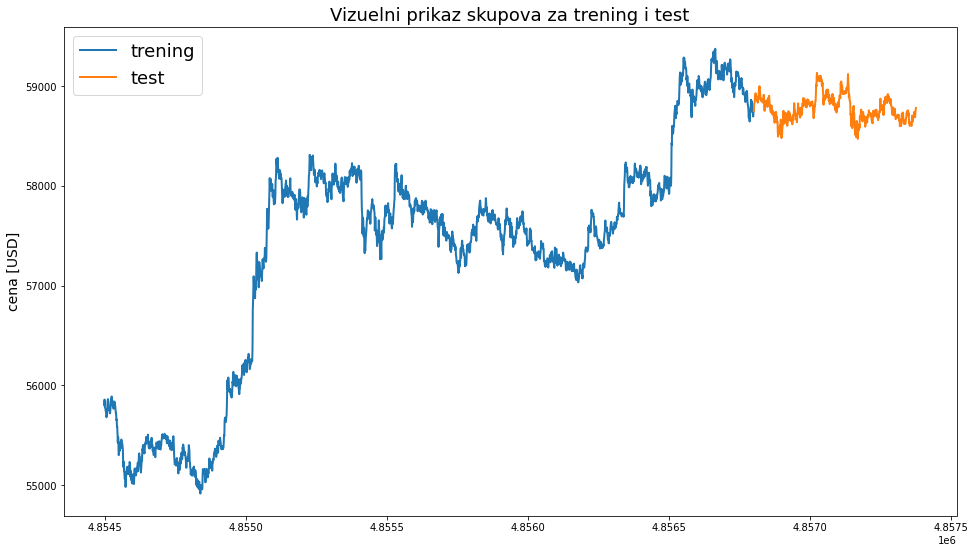

In [10]:
# Plotovanje train i test skupa podataka

plot_data(train_data = train['Close'], test_data = test['Close'])

## **Priprema trening skupa**

## **Filtriranje atributa train skupa**

In [11]:
# Izbacivanje nepotrebnih kolona (atributa) iz train skupa

train_ = train.drop(['Low', 'High', 'Open', 'Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
train_.head()

,Close
4854496,55804.36
4854497,55857.28
4854498,55779.04
4854500,55768.63
4854501,55742.20


In [12]:
# Dimenzije train skupa - pre i nakon izbacivanja atributa

train.shape, train_.shape

((2298, 9), (2298, 1))

## **Skaliranje train skupa**

In [13]:
# Skaliranje trening skupa

scaler = MinMaxScaler(feature_range=(0, 1))
train_ = scaler.fit_transform(train_)
train_

array([[0.19947492],
       [0.21134984],
       [0.19379327],
       ...,
       [0.84805843],
       [0.84788789],
       [0.86661356]])

## **Odredjivanje ciljne promenljive na train skupu**

In [14]:
# Odredjivanje ciljne promenljive na train skupu

X_train = []
y_train = []

for i in range(60, train_.shape[0]):
    X_train.append(train_[i-60:i])
    y_train.append(train_[i,0])


# train.shape = 100
# i in (60, 100)
# x_train.append(train[i-60:i])
# y_train.append(train[i, 0])

# i = 61
# x_train - train[1:61]
# y_train - train[61, 0]

# i = 62
# x_train - train[1:61] + train[2:62]
# y_train - train[61, 0] + train[62, 0]

# ...

# i = 99
# x_train - train[1:61] + train[2:62] + ... + train[33:99]
# y_train - train[61, 0] + train[62, 0] + ... + train[99, 0]


In [15]:
# Konverzija u np.array

X_train, y_train = np.array(X_train), np.array(y_train)

In [16]:
# Dimenzije X_train

X_train.shape

(2238, 60, 1)

## **Kreiranje, kompilacija i treniranje mreze**

### **Kreiranje mreze**

In [17]:
# Definicija funkcije koja kreira i vraca model mreze

def build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2]):

  net = Sequential()
  net.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (input_1, input_2)))
  net.add(Dropout(0.2))
  net.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.3))

  net.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.4))

  net.add(LSTM(units = 120, activation = 'relu'))
  net.add(Dropout(0.5))

  net.add(Dense(units =1))
  print(net.summary())

  return net


In [18]:
# Kreiranje modela mreze

net = build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

### **Kompilacija i treniranje mreze**

In [19]:
# Definicija funkcije za kompilaciju i treniranje mreze
# Treniranje je moguce vrsiti sa ili bez validacije

def compile_and_fit(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'mse', X_train_ = X_train, y_train_ = y_train, epochs = 20, validation = 0.1, batch_size = 50, patience=3):

  net.compile(optimizer = optimizer, loss = loss, metrics = metrics)

  callback = callbacks.EarlyStopping(monitor = 'loss', patience = patience)

  if validation == 0:
    history = net.fit(X_train_, y_train_, epochs = epochs, batch_size = batch_size, callbacks=[callback])
  else:
    history = net.fit(X_train_, y_train_, epochs = epochs, validation_split = validation, batch_size = batch_size, callbacks=[callback])

  return history, net


In [20]:
# Kompilacija i treniranje mreze sa validacijom

history_validation, net_validation = compile_and_fit(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'], X_train_ = X_train, y_train_ = y_train, epochs = 20, validation = 0.1, batch_size = 50, patience=3)


# Kompilacija i treniranje mreze bez validacije

history_no_validation, net_no_validation = compile_and_fit(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'], X_train_ = X_train, y_train_ = y_train, epochs = 20, validation = 0, batch_size = 50, patience=3)


Epoch 1/20
41/41 [==============================] - 14s 225ms/step - loss: 0.0783 - mse: 0.0783 - mae: 0.2178 - val_loss: 0.0334 - val_mse: 0.0334 - val_mae: 0.1807
Epoch 2/20
41/41 [==============================] - 9s 209ms/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0877 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0698
Epoch 3/20
41/41 [==============================] - 9s 210ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0752 - val_loss: 0.0023 - val_mse: 0.0023 - val_mae: 0.0402
Epoch 4/20
41/41 [==============================] - 9s 210ms/step - loss: 0.0085 - mse: 0.0085 - mae: 0.0706 - val_loss: 0.0049 - val_mse: 0.0049 - val_mae: 0.0645
Epoch 5/20
41/41 [==============================] - 9s 210ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0675 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0843
Epoch 6/20
41/41 [==============================] - 9s 210ms/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0683 - val_loss: 0.0132 - val_mse: 0.0132 - val_mae: 0.1114
Epoch 7/20
41/4

## **Priprema test skupa**

### **Filtriranje atributa test skupa**

In [21]:
# Izbacivanje nepotrebnih kolona (atributa) iz test skupa

test_ = test.drop(['Low', 'High', 'Open', 'Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)


### **Skaliranje test skupa**

In [22]:
# Skaliranje test skupa

test_ = scaler.transform(test_)

### **Odredjivanje ciljne promenljive na test skupu**

In [23]:
# Odredjivanje ciljne (target) promenljive na test skupu

X_test = []
y_test = []

for i in range(60, test_.shape[0]):
    X_test.append(test_[i-60:i])
    y_test.append(test_[i,0])
    

In [24]:
# Konverzija u np.array

X_test, y_test = np.array(X_test), np.array(y_test)

## **Predvidjanje**

In [25]:
# Predvidjanje za mrezu treniranu bez i sa validacijom

# Bez validacije
y_predicted_no_validation = net_no_validation.predict(X_test)
print('Predvidjene vrednosti (prvih 10) - bez validacije:\n', y_predicted_no_validation[:10])

# Sa validacijom
y_predicted_validation = net_validation.predict(X_test)
print('\nPredvidjene vrednosti (prvih 10) - sa validacijom:\n', y_predicted_validation[:10])

Predvidjene vrednosti (prvih 10) - bez validacije:
 [[0.851523  ]
 [0.85062045]
 [0.84922475]
 [0.84753186]
 [0.8457416 ]
 [0.8439362 ]
 [0.8421609 ]
 [0.8404041 ]
 [0.838671  ]
 [0.83702   ]]

Predvidjene vrednosti (prvih 10) - sa validacijom:
 [[0.851523  ]
 [0.85062045]
 [0.84922475]
 [0.84753186]
 [0.8457416 ]
 [0.8439362 ]
 [0.8421609 ]
 [0.8404041 ]
 [0.838671  ]
 [0.83702   ]]


## **Vizualizacija rezultata predvidjanja i metrika**

### **Vizuelni prikaz predvidjene i stvarne vrednosti**

In [26]:
# Vizuelni prikaz rezultata modela mreze

def plot_real_vs_predicted_data(test_set, predicted_set):

  fig, ax = plt.subplots(1, figsize=(16, 9))
  ax.plot(test_set, label='Stvarna vrednost BTC', linewidth=2)
  ax.plot(predicted_set, label='Predvidjena vrednost BTC', linewidth=2)
  ax.set_xlabel('Redni broj instance', fontsize=14)
  ax.set_ylabel('Cena [USD]', fontsize=14)
  ax.set_title(label = 'Vizuelni prikaz stvarne i predvidjene vrednosti BTC', fontsize=18)
  ax.legend(loc='best', fontsize=18)

  # test = test.reset_index()
  # x = test.index


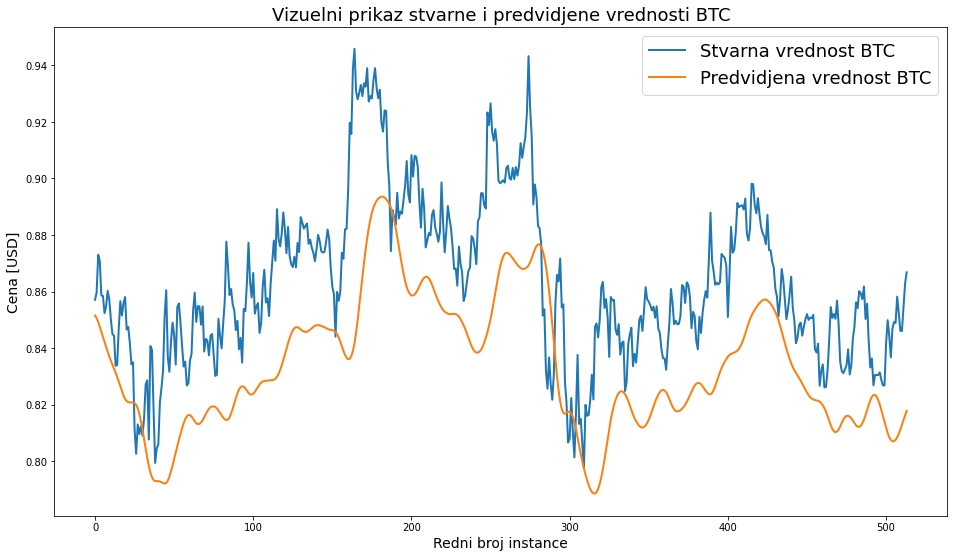

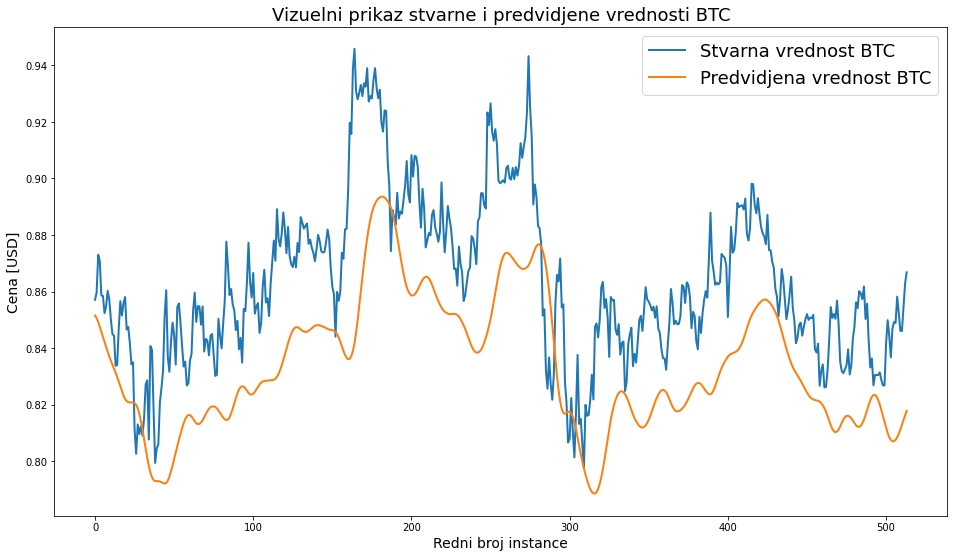

In [27]:
# Plotovanje stvarne i predvidjene vrednosti

# Bez validacije
plot_real_vs_predicted_data(test_set = y_test, predicted_set = y_predicted_no_validation)

# Sa validacijom
plot_real_vs_predicted_data(test_set = y_test, predicted_set = y_predicted_validation)

### **Vizuelni prikaz gubitka, tacnosti i srednje apsolutne greske tokom treniranja mreze (sa i bez validacije)**

In [28]:
# Vizuelni prikaz gubitka

def plot_loss(history_):

  epochs = range(len(history_.history['loss'])) # broj epoha
  plt.title('Vizuelni prikaz gubitka (loss)')
  plt.xlabel('broj epohe')
  plt.ylabel('gubitak')

  plt.plot(epochs, history_.history['loss'], label='Gubitak (loss) tokom treniranja')

  if 'val_loss' in history_.history:
    plt.plot(epochs, history_.history['val_loss'], label='Gubitak (val_loss) tokom treniranja sa validacijom')

  plt.legend(loc = 'best')

  plt.show()


In [29]:
# Vizuelni prikaz tacnosti

def plot_mse(history_):

  epochs = range(len(history_.history['mse'])) # broj epoha
  plt.title('Vizuelni prikaz MSE (mse')
  plt.xlabel('broj epohe')
  plt.ylabel('tacnost')
  
  plt.plot(epochs, history_.history['mse'], label='MSE (mse) tokom treniranja')

  if 'val_mse' in history_.history:
    plt.plot(epochs, history_.history['val_mse'], label='MSE (val_mse) tokom treniranja sa validacijom')

  plt.legend(loc = 'best')

  plt.show()


In [30]:
# Vizuelni prikaz MAE

def plot_mae(history_):

  epochs = range(len(history_.history['mae'])) # broj epoha
  plt.title('Vizuelni prikaz MAE (mae')
  plt.xlabel('broj epohe')
  plt.ylabel('MAE')
  
  plt.plot(epochs, history_.history['mae'], label='MAE (mae) tokom treniranja')

  if 'val_mae' in history_.history:
    plt.plot(epochs, history_.history['val_mae'], label='MAE (val_mae) tokom treniranja sa validacijom')

  plt.legend(loc = 'best')

  plt.show()


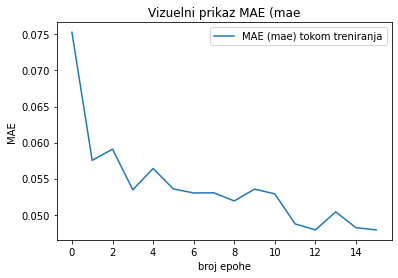

In [31]:
# MAE

plot_mae(history_no_validation)

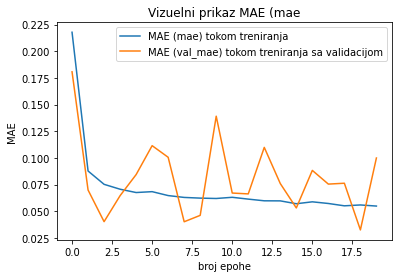

In [32]:
# MAE - sa validacijom

plot_mae(history_validation)

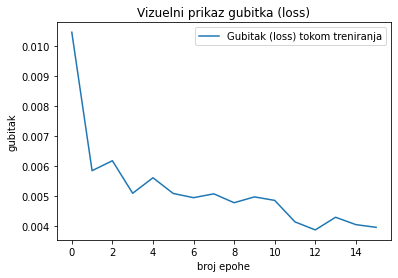

In [33]:
# Loss

plot_loss(history_no_validation)

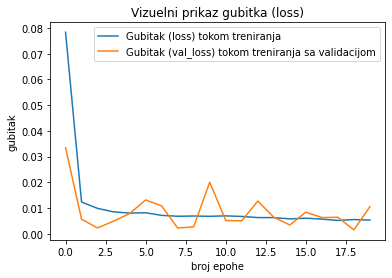

In [34]:
# Loss - sa validacijom

plot_loss(history_validation)

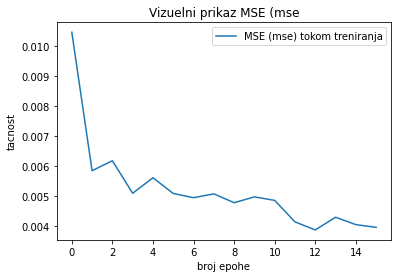

In [35]:
# MSE

plot_mse(history_no_validation)

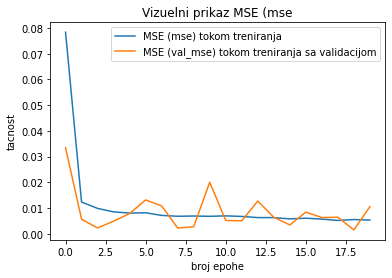

In [36]:
# MSE - validation

plot_mse(history_validation)

In [37]:
# Loss, MSE, MAE nad skupom za testiranje

# (za model koji pri treniranju koristi validaciju
# i za model koji pri treniranju ne koristi validaciju)

test_metrics_no_val = net_no_validation.evaluate(X_test, y_test)
test_metrics_val = net_validation.evaluate(X_test, y_test)

print('\nMetrike prilikom testiranja - model treniran bez validacije\n')
print(net_no_validation.metrics_names[0], test_metrics_no_val[0])
print(net_no_validation.metrics_names[1], test_metrics_no_val[1])
print(net_no_validation.metrics_names[2], test_metrics_no_val[2])

print('\n\nMetrike prilikom testiranja - model treniran sa validacijom\n')
print(net_validation.metrics_names[0], test_metrics_val[0])
print(net_validation.metrics_names[1], test_metrics_val[1])
print(net_validation.metrics_names[2], test_metrics_val[2])


17/17 [==============================] - 1s 42ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0304

Metrike prilikom testiranja - model treniran bez validacije

loss 0.001184426131658256
mse 0.001184426131658256
mae 0.03036387637257576


Metrike prilikom testiranja - model treniran sa validacijom

loss 0.001184426131658256
mse 0.001184426131658256
mae 0.03036387637257576


In [38]:
# R2 skor nad skupom za testiranje

r2 = metrics.r2_score(y_predicted_no_validation, y_test)
r2_val = metrics.r2_score(y_predicted_validation, y_test)

print('R2 skor prilikom testiranja - model treniran bez validacije', r2)
print('R2 skor prilikom testiranja - model treniran sa validacijom', r2_val)

R2 skor prilikom testiranja - model treniran bez validacije -1.1979718723305983
R2 skor prilikom testiranja - model treniran sa validacijom -1.1979718723305983
